<a href="https://colab.research.google.com/github/fuserkuba/HackerRank/blob/master/StackExchangeQuestionClassifier/HR_Stack_Exchange_Question_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [127]:
import pandas as pd
import numpy as np
import requests

path='https://raw.githubusercontent.com/fuserkuba/HackerRank/master/StackExchangeQuestionClassifier/'

input_file=path+'stack-exchange-question-classifier-testcases/input/input00.txt'
input=requests.get(input_file).text.split("\n")

output_file=path+'stack-exchange-question-classifier-testcases/output/output00.txt'
output=requests.get(output_file).text.split("\n")

training_file=path+'training.json'
training=requests.get(training_file).text.split("\n")


# **READING INPUT**

In [128]:
import json

training_iter=iter(training)
#T training cases follow. 
T=int(next(training_iter))
df_train=pd.DataFrame([json.loads(next(training_iter)) for _ in range(T)])

input_iter=iter(input)
#T test cases follow. 
T=int(next(input_iter))
df_input=pd.DataFrame([json.loads(next(input_iter)) for _ in range(T)])

y_column='topic'
df_output=pd.DataFrame(output,columns=[y_column])


# **EXPLORATORY DATA ANALYSIS**

topic       object
question    object
excerpt     object
dtype: object
<bound method DataFrame.info of              topic  ...                                            excerpt
0      electronics  ...  I'm trying to work out, in general terms, the ...
1      electronics  ...  Can I know which component senses heat or acts...
2      electronics  ...  I am replacing a wall outlet with a Cooper Wir...
3      electronics  ...  i have been reading about the buck converter, ...
4      electronics  ...  I need help with deciding on a Master's Projec...
...            ...  ...                                                ...
20214    wordpress  ...  I have a Custom Post Type called Recipe with p...
20215    wordpress  ...  I'm using the code below to track when a user ...
20216    wordpress  ...  add_action( 'pre_get_posts', 'custom_pre_get_p...
20217    wordpress  ...  i have wordpress blog with many posts. each po...
20218    wordpress  ...  I have many issues with the use of rewriting, .

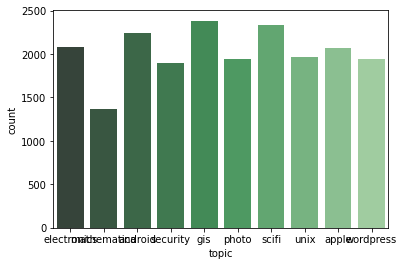

In [129]:
import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
from sklearn.preprocessing import StandardScaler

print(df_train.dtypes)
print(df_train.info)
print(df_train.describe())

print(df_input.dtypes)
print(df_input.info)
print(df_input.describe())


sns.countplot(x=y_column,data=df_train,palette="Greens_d")


# **PREPARE TRAIN AND TEST DATA**

In [185]:
#Encode topic as categories
#df_train.topic=df_train.topic.astype('category')
df_train.question.fillna('', inplace=True)

# Taking question + excerpt as feature
X_train=(df_train.question+df_train.excerpt).values
y_train=df_train.topic.values
X_test=(df_input.question+df_input.excerpt).values

y_test=df_output[df_output[y_column]!=""].values#.reshape(1,-1)

#y_test=np.array(list(filter(None,y_test)))
print(y_test.shape)


print(df_train.info())
print(X_train.shape,X_train[:5],sep='\n')
print(y_train.shape,y_train[:5],sep='\n')

print(X_test.shape,X_test[:10])
print(y_test.shape)#,y_test[-10:])

(21345, 1)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20219 entries, 0 to 20218
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   topic     20219 non-null  object
 1   question  20219 non-null  object
 2   excerpt   20219 non-null  object
dtypes: object(3)
memory usage: 474.0+ KB
None
(20219,)
["What is the effective differencial effective of this circuitI'm trying to work out, in general terms, the effective capacitance of this circuit (see diagram: http://i.stack.imgur.com/BS85b.png).  \n\nWhat is the effective capacitance of this circuit and will the ...\r\n        "
 'Heat sensor with fan coolingCan I know which component senses heat or acts as heat sensor in the following circuit?\nIn the given diagram, it is said that the 4148 diode acts as the sensor. But basically it is a zener diode and ...\r\n        '
 'Outlet Installation--more wires than my new outlet can use [on hold]I am replacing a wall outlet with a 

# **TRAIN MODEL**

In [199]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import HashingVectorizer
#
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
#
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
#
from pprint import pprint
from time import time

#TOKENS_BASIC = '\\\\S+(?=\\\\s+)'
#Only words without numbers
TOKENS_PATTERN='[^\d\W]+'

#Convert a collection of text documents to a matrix of token counts
vec_basic = CountVectorizer(max_df=0.5,
                            max_features=50000,
                            ngram_range=(1, 2),
                            stop_words='english',
                            token_pattern=TOKENS_PATTERN)


vect = HashingVectorizer(alternate_sign=True, analyzer='word',
                                   binary=False, decode_error='strict',
                                   encoding='utf-8', input='content',
                                   lowercase=True, n_features=1048576,
                                   ngram_range=(1, 2), norm=None,
                                   preprocessor=None, stop_words='english',
                                   strip_accents=None,
                                   token_pattern='[^\\d\\W]+',
                                   tokenizer=None)

#X_train_vec=vec_basic.fit_transform(X_train)

#Transform a count matrix to a normalized tf or tf-idf representation
tfidf=TfidfTransformer(norm='l2', smooth_idf=True,sublinear_tf=False, use_idf=True)

#X_train_tdidf=tfidf.fit_transform(X_train_vec)
#print(X_train_vec.shape)
#print(X_train_tdidf.shape)
#print("There are {} tokwens".format(len(vec_basic.get_feature_names())))
#print(vec_basic.get_feature_names()[:10])

#clf=MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

#Linear classifiers (SVM, logistic regression, etc.) with SGD training.
#This estimator implements regularized linear models with stochastic gradient descent (SGD) learnin
clf=SGDClassifier(alpha=0.001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                               max_iter=100, n_iter_no_change=5, n_jobs=None,
                               penalty='l2', power_t=0.5, random_state=None,
                               shuffle=True, tol=0.001, validation_fraction=0.1,
                               verbose=0, warm_start=False)

# Define a pipeline combining a text feature extractor with a simple classifier
pipeline = Pipeline([
    ('vect', vect),
    #('tfidf', tfidf),
    ('clf', clf),
])

#Define params
parameters = {
    #'vect__max_df': (0.5, 0.75, 1.0),
    #'vect__max_features': (50000, 100000,500000),
    #'vect__ngram_range': ((2, 2), (1, 2)),  # unigrams or bigrams
    #'vect__token_pattern': (TOKENS_PATTERN,), # Regular expression denoting what constitutes a “token”
    'vect__stop_words': ('english',), # If ‘english’, a built-in stop word list for English is used
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': (0.0015,0.005,0.009),
    'clf__penalty': ('l2', 'l1', 'elasticnet'),
    'clf__max_iter':(1000,1500),
}

# find the best parameters for both the feature extraction and the classifier
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))
print()
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
  print("\t%s: %r" % (param_name, best_parameters[param_name]))


model=grid_search.best_estimator_

print(model)

Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'clf__alpha': (0.0015, 0.005, 0.009),
 'clf__max_iter': (1000, 1500),
 'clf__penalty': ('l2', 'l1', 'elasticnet'),
 'vect__stop_words': ('english',)}
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  3.8min finished


done in 228.283s

Best score: 0.904
Best parameters set:
	clf__alpha: 0.0015
	clf__max_iter: 1500
	clf__penalty: 'l2'
	vect__stop_words: 'english'
Pipeline(memory=None,
         steps=[('vect',
                 HashingVectorizer(alternate_sign=True, analyzer='word',
                                   binary=False, decode_error='strict',
                                   dtype=<class 'numpy.float64'>,
                                   encoding='utf-8', input='content',
                                   lowercase=True, n_features=1048576,
                                   ngram_range=(1, 2), norm=None,
                                   preprocessor=None, stop_words='english',
                                   strip_accents=None,
                                   token_pattern='[^\\d\\W]+',
                                   tokenizer=None))...
                 SGDClassifier(alpha=0.0015, average=False, class_weight=None,
                               early_stopping=False, epsilon

# **TEST MODEL**

In [200]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


y_pred=model.predict(X_test)
print("confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))



confusion matrix:
[[2136   49   25   11    7   15   14   30   29    8]
 [  74 1819   13    9   10   23   24   61  130   21]
 [  27   10 2131    7   30   17   30   19   23    2]
 [   6   10    8 2349   35    6   13   18   19   15]
 [   2    8   20   48 1311   15   22    8   27   10]
 [  11   14   19    6    9 1971   22    8    6    4]
 [   2    1   10    2    9    5 2407    6    1    0]
 [  45   44   25   16   11    5   21 1690   98   36]
 [  26   85   30   17   22    9   20  106 1677   22]
 [   6    5    7    6    9    7    8   25    9 1991]]
              precision    recall  f1-score   support

     android       0.91      0.92      0.92      2324
       apple       0.89      0.83      0.86      2184
 electronics       0.93      0.93      0.93      2296
         gis       0.95      0.95      0.95      2479
 mathematica       0.90      0.89      0.90      1471
       photo       0.95      0.95      0.95      2070
       scifi       0.93      0.99      0.96      2443
    security      